# Capstone Project - The Battle of the Neighborhoods 

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find optimal location for a gymnasium.Specifically, this report will be targeted to stakeholders interested in opening a **Gymnasium** in **Toronto**, Canada.

Since there are lots of gymnasiums and fitness centers in Toronto we will try to detect **locations that are not already crowded with gymnasiums** or any kind of **fitness centers**. We are also particularly interested in **areas with no fitness centers in vicinity**. We would also prefer locations with **high population** and **less number of fitness centers per population**, assuming that first two conditions are met. 

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing gymnasiums and fitness centers in the neighborhood 
* population in the neighbourhood
* population density, average income etc

Following data sources will be needed to extract/generate the required information:
* Toronto neighbourhood data and population information could be obtained from wikipedia. The links are: 

    - <a href='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'>Toronto neighbourhood data</a>
    - <a href='https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'>Demographics of Toronto neighbourhood</a>
    
* number of gymnasiums/fitness centers and their location in every neighborhood will be obtained using **Foursquare API**

#### First let's get Toronto neighbourhood data and create a dataframe

In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import json
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
toronto_data=pd.read_html(url)
ty_neighbourhoods_data=toronto_data[0]
ty_neighbourhoods_data.Borough.replace('Not assigned',np.nan,inplace=True)
ty_neighbourhoods_data.dropna(axis=0,inplace=True)
ty_neighbourhoods_data.reset_index(drop=True,inplace=True)
ty_neighbourhoods_data.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [2]:
ty_neighbourhoods_data.shape

(103, 3)

#### Now we need latitude and longitude for each neighbourhood

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
geo_data = pd.read_csv(body)
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merge two dataframes together

In [5]:
ty_neighbourhoods=pd.merge(ty_neighbourhoods_data,geo_data,on='Postal Code')
ty_neighbourhoods.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [6]:
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

In [7]:
ty_neighbourhoods.rename(columns={'Neighbourhood':'Neighborhood'},inplace=True)
# calculate lengths of splits
lens = ty_neighbourhoods['Neighborhood'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
df_temp = pd.DataFrame({'Borough':np.repeat(ty_neighbourhoods['Borough'], lens),
                    'Neighborhood': chainer(ty_neighbourhoods['Neighborhood']),
                    'Latitude': np.repeat(ty_neighbourhoods['Latitude'], lens),
                    'Longitude': np.repeat(ty_neighbourhoods['Longitude'], lens)})

# drop duplicate records
ty_neighbourhoods = df_temp.drop_duplicates(subset='Neighborhood')
ty_neighbourhoods.reset_index(drop=True,inplace=True)
ty_neighbourhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,Regent Park,43.654260,-79.360636
3,Downtown Toronto,Harbourfront,43.654260,-79.360636
4,North York,Lawrence Manor,43.718518,-79.464763


In [8]:
ty_neighbourhoods.shape

(209, 4)

#### Next, lets search for population related information 

In [10]:
url='https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
toronto_population=pd.read_html(url)
temp=[]
for i in range(1,6):
    temp.append(toronto_population[i])
toronto_population_df=pd.concat(temp)
toronto_population_df.reset_index(drop=True,inplace=True)
toronto_population_df=toronto_population_df[['Name','Population','Land area (km2)','Average Income']]
toronto_population_df.rename(columns={'Name':'Neighborhood'},inplace=True)
toronto_population_df.head()

,Neighborhood,Population,Land area (km2),Average Income
0,Crescent Town,8157.0,0.40,23021.0
1,Governor's Bridge/Bennington Heights,2112.0,1.87,129904.0
2,Leaside,13876.0,2.81,82670.0
3,O'Connor–Parkview,17740.0,4.94,33517.0
4,Old East York,52220.0,7.94,33172.0


In [11]:
toronto_population_df.shape

(177, 4)

**Merge population data with location data**

In [12]:
toronto_df=pd.merge(ty_neighbourhoods,toronto_population_df,on='Neighborhood')
toronto_df.head()

,Borough,Neighborhood,Latitude,Longitude,Population,Land area (km2),Average Income
0,North York,Parkwoods,43.753259,-79.329656,26533.0,4.96,34811.0
1,North York,Victoria Village,43.725882,-79.315572,17047.0,4.72,29657.0
2,North York,Lawrence Manor,43.718518,-79.464763,13750.0,2.14,36361.0
3,Scarborough,Malvern,43.806686,-79.194353,44324.0,8.86,25677.0
4,North York,Don Mills,43.745906,-79.352188,21372.0,8.99,47515.0


In [13]:
# The code was removed by Watson Studio for sharing.

209

In [14]:
# The code was removed by Watson Studio for sharing.

174

In [15]:
# The code was removed by Watson Studio for sharing.

(46, 7)

In [18]:
#pip install folium
import folium
from geopy.geocoders import Nominatim

address='Toronto, ON'

geolocator = Nominatim(user_agent="foursquare_api")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [19]:
# create map of Toronto using latitude and longitude values
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

So our goal is to find which among the neighbourhood shown above is best suitable for starting a **Gymnasium**

Now, lets get nearest venues of each neighbourhoods 

In [20]:
# The code was removed by Watson Studio for sharing.

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,  
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
toronto_venues=getNearbyVenues(names=toronto_df['Neighborhood'],latitudes=toronto_df['Latitude'],longitudes=toronto_df['Longitude'])
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
2,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
3,Parkwoods,43.753259,-79.329656,Galleria Supermarket,43.753520,-79.349518,Supermarket
4,Parkwoods,43.753259,-79.329656,Island Foods,43.745866,-79.346035,Caribbean Restaurant


In [23]:
toronto_venues.size

32018

In [24]:
toronto_venues['Neighborhood'].unique().size

46

In [25]:
print('There are {} Venues found for {} Neighbourhood in Toronto'.format(toronto_venues.size,toronto_venues['Neighborhood'].unique().size))

There are 32018 Venues found for 46 Neighbourhood in Toronto


In [26]:
df=pd.merge(toronto_df,toronto_venues,on='Neighborhood')
df.head()

,Borough,Neighborhood,Latitude,Longitude,Population,Land area (km2),Average Income,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.753259,-79.329656,26533.0,4.96,34811.0,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,North York,Parkwoods,43.753259,-79.329656,26533.0,4.96,34811.0,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
2,North York,Parkwoods,43.753259,-79.329656,26533.0,4.96,34811.0,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
3,North York,Parkwoods,43.753259,-79.329656,26533.0,4.96,34811.0,43.753259,-79.329656,Galleria Supermarket,43.753520,-79.349518,Supermarket
4,North York,Parkwoods,43.753259,-79.329656,26533.0,4.96,34811.0,43.753259,-79.329656,Island Foods,43.745866,-79.346035,Caribbean Restaurant


**Data collection, Data Understandind and Preperation** have been done and the final dataframe is the one above.

In [27]:
df.shape

(4574, 13)

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Toronto that have lesser number of Gymnasiums.

In first step we have collected the required **data: location and category of every venues from neighbourhoods of Toronto**. 

Second step in our analysis will be calculation and exploration of '**number of gyms**' across different neighbourhoods of Toronto.So, From the data we need to identify neighbourhoods which do not have atleast one gym. 

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with **not even one gym in single neighbourhood**, and we want locations **with high population and high population density**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of gymnasiums in every neighbourhood candidate**:

In [28]:
df[df['Venue Category']=='Gym'].shape

(74, 13)

In [29]:
toronto_gym=df[df['Venue Category']=='Gym']
toronto_gym.reset_index(drop=True,inplace=True)
toronto_gym.tail()

,Borough,Neighborhood,Latitude,Longitude,Population,Land area (km2),Average Income,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
69,Etobicoke,New Toronto,43.605647,-79.501321,10455.0,2.71,33415.0,43.605647,-79.501321,Toronto Gymnastics International,43.599832,-79.542924,Gym
70,Etobicoke,Alderwood,43.602414,-79.543484,11656.0,4.94,35239.0,43.602414,-79.543484,Toronto Gymnastics International,43.599832,-79.542924,Gym
71,Etobicoke,Alderwood,43.602414,-79.543484,11656.0,4.94,35239.0,43.602414,-79.543484,Fit4Less,43.620342,-79.523957,Gym
72,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,13397.0,0.55,37653.0,43.665860,-79.383160,Hone Fitness,43.667484,-79.385510,Gym
73,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,13397.0,0.55,37653.0,43.665860,-79.383160,GoodLife Fitness Toronto Bloor and Park,43.671302,-79.384691,Gym


In [30]:
toronto_gym.shape

(74, 13)

In [31]:
toronto_gym_count=toronto_gym[['Neighborhood','Venue Category']].groupby('Neighborhood').count().transpose()   #gym count in neighbourhoods
toronto_gym_count                   

Neighborhood,Agincourt,Alderwood,Bathurst Manor,Bedford Park,Birch Cliff,Brockton,Church and Wellesley,Cliffside,Davisville,Don Mills,...,St. James Town,The Annex,The Beaches,Thorncliffe Park,Victoria Village,Westmount,Weston,Wexford,Woburn,York Mills
Venue Category,1,2,2,1,2,1,2,5,4,2,...,2,2,2,3,1,2,1,3,3,3


#### This is the number of gyms in neighbourhoods which have atleast one gymnasium

In [32]:
print('33 neighbourhoods have atleast one gym')              #33 columns in above dataframe
print('13 neighbourhoods do not have atleast one gym')       #Total 46 neighbourhoods we have selected so 46-33=13 do not have atleast one gym

33 neighbourhoods have atleast one gym
13 neighbourhoods do not have atleast one gym


**So, let's find those 13 neighbourhoods first and explore it.**

In [33]:
neigh_no_gym=set()                                     #set will not store one vallue twice. So to get unique neighbourhoods use a set 
for neigh in toronto_venues['Neighborhood']:           #check, out of all neighbourhoods which dont have atleast one gym
    if neigh in toronto_gym_count.columns.values:
        continue
    else:
        neigh_no_gym.add(neigh)
neigh_no_gym

{'Bayview Village',
 'Downsview',
 'Humber Summit',
 'Kensington Market',
 'Lawrence Manor',
 'Little Portugal',
 'Malvern',
 'Parkdale',
 'Rosedale',
 'Runnymede',
 'The Kingsway',
 'West Deane Park',
 'Willowdale'}

These are the 13 neighbourhoods in **Tornonto** which do not have atleast one gym. So let's recommend our stakeholders this list of neighbourhoods to start a gymnasium. Let's check more details such as population, population density etc about these 13 neighbourhoods.

In [34]:
toronto_no_gym=df[df['Neighborhood'].apply(lambda item:item in neigh_no_gym)].reset_index(drop=True)  #neighbourhoods with not atleast one gym
toronto_no_gym.head()

,Borough,Neighborhood,Latitude,Longitude,Population,Land area (km2),Average Income,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Lawrence Manor,43.718518,-79.464763,13750.0,2.14,36361.0,43.718518,-79.464763,Harvey's,43.715337,-79.455396,Restaurant
1,North York,Lawrence Manor,43.718518,-79.464763,13750.0,2.14,36361.0,43.718518,-79.464763,Crate & Barrel,43.726584,-79.452661,Furniture / Home Store
2,North York,Lawrence Manor,43.718518,-79.464763,13750.0,2.14,36361.0,43.718518,-79.464763,Yorkdale Shopping Centre,43.725482,-79.452736,Shopping Mall
3,North York,Lawrence Manor,43.718518,-79.464763,13750.0,2.14,36361.0,43.718518,-79.464763,BATLgrounds,43.724054,-79.463398,Athletics & Sports
4,North York,Lawrence Manor,43.718518,-79.464763,13750.0,2.14,36361.0,43.718518,-79.464763,The Burger's Priest,43.720789,-79.456766,Fast Food Restaurant


In [35]:
# create map of Neighbourhood in Toronto with no gym 
map_toronto_no_gym= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(toronto_no_gym['Latitude'], toronto_no_gym['Longitude'], toronto_no_gym['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_no_gym)  
    
map_toronto_no_gym

In [38]:
df_neigh_no_gym=toronto_no_gym[['Neighborhood','Population','Land area (km2)','Average Income']].drop_duplicates(subset ='Neighborhood').set_index('Neighborhood')
df_neigh_no_gym.sort_values(by='Population',axis=0,ascending=False,inplace=True)
df_neigh_no_gym

,Population,Land area (km2),Average Income
Neighborhood,,,
Malvern,44324.0,8.86,25677.0
Willowdale,43144.0,7.68,39895.0
Downsview,36613.0,16.13,26751.0
Parkdale,28367.0,2.03,26314.0
Lawrence Manor,13750.0,2.14,36361.0
Humber Summit,12766.0,7.89,26117.0
Bayview Village,12280.0,4.14,46752.0
The Kingsway,8780.0,2.58,110944.0
Rosedale,7672.0,2.72,213941.0


Text(0, 0.5, 'Population')

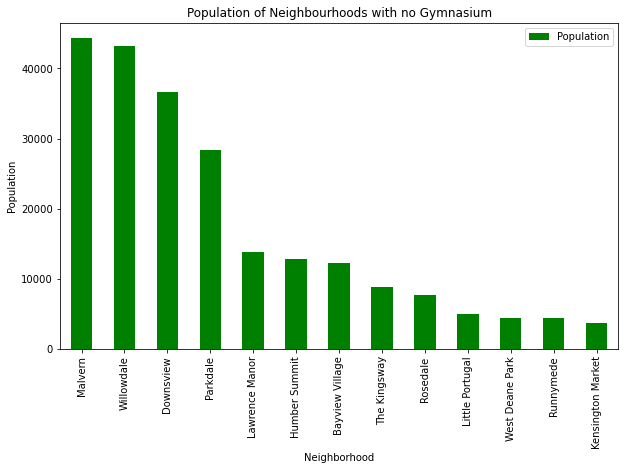

In [39]:
df_neigh_no_gym[['Population']].plot(kind='bar',
                                    figsize=(10,6),
                                    color='green')
plt.title('Population of Neighbourhoods with no Gymnasium')
plt.ylabel('Population')

From the above graph, we could see among neighbourhoods which have no gym, **Malvern,Willowdale,Downsview,Parkdale** have high population

Next, let's check **population density** of each neighbourhood

Text(0, 0.5, 'Population Density')

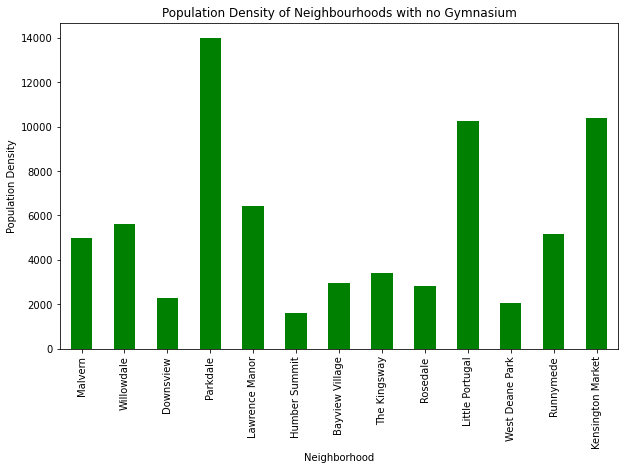

In [40]:
(df_neigh_no_gym['Population']/df_neigh_no_gym['Land area (km2)']).plot(kind='bar',
                                                                       figsize=(10,6),
                                                                        color='green')
plt.title('Population Density of Neighbourhoods with no Gymnasium')
plt.ylabel('Population Density')

Among high populated neighbourhoods such as **Malvern,Willowdale,Downsview,Parkdale**, first three has low population density.Only **Parkdale** has high population density among four.**Parkdale,Little Portugal,Kensington Market** have high population density.

Text(0.5, 1.0, 'Average Income of Neighbourhoods with no Gymnasium')

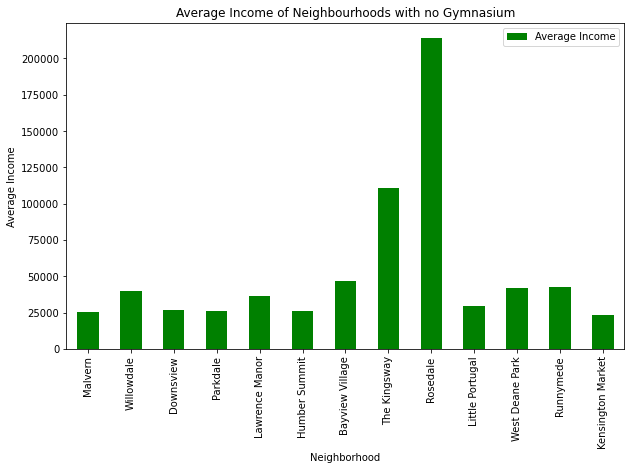

In [41]:
df_neigh_no_gym[['Average Income']].plot(kind='bar',
                                        figsize=(10,6),
                                        color='green')
plt.ylabel('Average Income')
plt.title('Average Income of Neighbourhoods with no Gymnasium')

From above two plots we have seen that **Rosedale** has low population and population density,but it high average income as compared to others. 

So let's say that **Parkdale** would be a best location to start a new gymnasium, because which have high population and high population density. Also let's choose other high density neighbourhoods like **Little Portugal,Kensington Market** as well. By considering population we can consider **Malvern,Willowdale,Downsview** in addition to **Parkdale**. If average income is also a concern then let's choose **Rosedale**. So out of 13 neighbourhoods with no gymnasiums 7 neighbourhoods are optimal locations to start a gym. They are :
- Parkdale
- Malvern
- Willowdale
- Downsview
- Little Portugal
- Kensington Market
- Rosedale

**out of 13 neighbourhoods other 6 are:**

In [42]:
neigh_no_gym.difference_update(['Parkdale','Malvern','Willowdale','Downsview','Little Portugal','Kensington Market','Rosedale'])
neigh_no_gym

{'Bayview Village',
 'Humber Summit',
 'Lawrence Manor',
 'Runnymede',
 'The Kingsway',
 'West Deane Park'}

Looking good. What we have now is a clear indication of zones with zero gyms, among them locations with high and low **population,population density and average income**.

Let us now **cluster** those locations to create **centers of zones containing good locations**. Those zones, their centers and addresses will be the final result of our analysis. 

In [44]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_no_gym[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_no_gym['Neighborhood'] 
loc=toronto_onehot.columns.get_loc('Neighborhood')

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[loc]] + list(toronto_onehot.columns[0:loc])+list(toronto_onehot.columns[loc+1:])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Lawrence Manor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Manor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Manor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Lawrence Manor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Lawrence Manor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
toronto_onehot.shape

(1300, 211)

In [46]:
toronto_grouped=toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bayview Village,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Downsview,0,1,2,0,0,0,0,1,0,...,0,3,1,0,0,0,0,0,0,0
2,Humber Summit,0,0,1,0,0,0,0,0,1,...,0,2,1,0,0,0,0,0,0,0
3,Kensington Market,0,0,0,0,0,0,2,1,0,...,6,2,0,0,1,0,0,2,0,0
4,Lawrence Manor,0,1,2,0,0,0,0,1,0,...,0,2,1,0,0,0,1,0,0,0
5,Little Portugal,0,0,1,0,0,0,1,0,3,...,3,2,0,1,2,0,0,1,0,0
6,Malvern,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,11
7,Parkdale,0,0,1,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
8,Rosedale,1,0,0,0,0,0,1,0,0,...,2,0,0,0,1,0,0,2,0,0
9,Runnymede,0,0,0,0,1,0,0,2,1,...,0,2,0,0,0,0,0,1,0,0


In [47]:
toronto_grouped.shape       

(13, 211)

The above table shows categories and number of each venues present in the selected **13 neighbourhoods with no gyms**. For the purpose of clustering let's choose 10 most common venues in each neighbourhoods.

First, let's write a function to sort the venues in descending order.

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview Village,Coffee Shop,Korean Restaurant,Café,Supermarket,Chinese Restaurant,Bank,Bubble Tea Shop,Sushi Restaurant,Furniture / Home Store,Shopping Mall
1,Downsview,Clothing Store,Coffee Shop,Furniture / Home Store,Bank,Vietnamese Restaurant,Cosmetics Shop,Restaurant,Sandwich Place,Grocery Store,Deli / Bodega
2,Humber Summit,Coffee Shop,Bank,Indian Restaurant,Sandwich Place,Italian Restaurant,Steakhouse,Pharmacy,Pizza Place,Fast Food Restaurant,Burger Joint
3,Kensington Market,Bar,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Mexican Restaurant,Park,Ice Cream Shop,Bakery,Yoga Studio,Vietnamese Restaurant
4,Lawrence Manor,Clothing Store,Coffee Shop,Furniture / Home Store,Restaurant,Grocery Store,Fast Food Restaurant,Falafel Restaurant,Cosmetics Shop,Dessert Shop,Men's Store


In [50]:
neighborhoods_venues_sorted.shape

(13, 11)

Now lets merge **df_neigh_no_gym** to merge population, land area and income information with **neighborhoods_venues_sorted** 

In [79]:
nogym_data=pd.merge(df_neigh_no_gym.reset_index(),neighborhoods_venues_sorted,on='Neighborhood')
nogym_data.head()

,Neighborhood,Population,Land area (km2),Average Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Malvern,44324.0,8.86,25677.0,Zoo Exhibit,Coffee Shop,Fast Food Restaurant,Gas Station,Sandwich Place,Indian Restaurant,Pharmacy,Breakfast Spot,Burger Joint,Restaurant
1,Willowdale,43144.0,7.68,39895.0,Korean Restaurant,Coffee Shop,Sushi Restaurant,Café,Supermarket,Pizza Place,Middle Eastern Restaurant,Fast Food Restaurant,Bank,Bubble Tea Shop
2,Downsview,36613.0,16.13,26751.0,Clothing Store,Coffee Shop,Furniture / Home Store,Bank,Vietnamese Restaurant,Cosmetics Shop,Restaurant,Sandwich Place,Grocery Store,Deli / Bodega
3,Parkdale,28367.0,2.03,26314.0,Coffee Shop,Café,Bakery,Park,Bar,Restaurant,Italian Restaurant,Gastropub,Eastern European Restaurant,Clothing Store
4,Lawrence Manor,13750.0,2.14,36361.0,Clothing Store,Coffee Shop,Furniture / Home Store,Restaurant,Grocery Store,Fast Food Restaurant,Falafel Restaurant,Cosmetics Shop,Dessert Shop,Men's Store


Now lets merge **df_neigh_no_gym** to merge population, land area and income information with **toronto_grouped** table which is the grouping of one hot encoded values of each neighbourhoods. The resulting dataset can be used for **Clustering**. Because we need numerical data to pass to clustering algorithm.

In [54]:
nogym_cluster=pd.merge(df_neigh_no_gym.reset_index(),toronto_grouped,on='Neighborhood')
nogym_cluster.head()

,Neighborhood,Population,Land area (km2),Average Income,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Malvern,44324.0,8.86,25677.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,11
1,Willowdale,43144.0,7.68,39895.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Downsview,36613.0,16.13,26751.0,0,1,2,0,0,0,...,0,3,1,0,0,0,0,0,0,0
3,Parkdale,28367.0,2.03,26314.0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,Lawrence Manor,13750.0,2.14,36361.0,0,1,2,0,0,0,...,0,2,1,0,0,0,1,0,0,0


So this data can be used for **clustering** 

In [55]:
nogym_cluster.shape

(13, 214)

Run **k-means** to cluster the neighborhood into 5 clusters.

In [99]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

kclusters =4

X = nogym_cluster.values[:,1:]
Clus_dataSet = StandardScaler().fit_transform(X)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)

In [100]:
nogym_data['Cluster']=kmeans.labels_

In [101]:
nogym_data_final=pd.merge((toronto_no_gym[['Neighborhood','Latitude','Longitude']].drop_duplicates(subset ='Neighborhood').reset_index(drop=True)),
        nogym_data,on='Neighborhood')

In [102]:
nogym_data_final.head()

,Neighborhood,Latitude,Longitude,Population,Land area (km2),Average Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,Lawrence Manor,43.718518,-79.464763,13750.0,2.14,36361.0,Clothing Store,Coffee Shop,Furniture / Home Store,Restaurant,Grocery Store,Fast Food Restaurant,Falafel Restaurant,Cosmetics Shop,Dessert Shop,Men's Store,1
1,Malvern,43.806686,-79.194353,44324.0,8.86,25677.0,Zoo Exhibit,Coffee Shop,Fast Food Restaurant,Gas Station,Sandwich Place,Indian Restaurant,Pharmacy,Breakfast Spot,Burger Joint,Restaurant,2
2,West Deane Park,43.650943,-79.554724,4395.0,2.13,41582.0,Burger Joint,Coffee Shop,Grocery Store,Liquor Store,Bakery,Breakfast Spot,Hotel,Italian Restaurant,Sporting Goods Shop,Golf Course,0
3,Little Portugal,43.647927,-79.419750,5013.0,0.49,29224.0,Café,Restaurant,Bar,Bakery,Coffee Shop,Italian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Cocktail Bar,Asian Restaurant,0
4,Bayview Village,43.786947,-79.385975,12280.0,4.14,46752.0,Coffee Shop,Korean Restaurant,Café,Supermarket,Chinese Restaurant,Bank,Bubble Tea Shop,Sushi Restaurant,Furniture / Home Store,Shopping Mall,2


Now lets plot the clusters in a map by using above dataset

In [103]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nogym_data_final['Latitude'], nogym_data_final['Longitude'], nogym_data_final['Neighborhood'], nogym_data_final['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

folium.LayerControl().add_to(map_clusters)
       
map_clusters

In [105]:
nogym_data_final[['Neighborhood','Cluster']].sort_values(by='Cluster').reset_index(drop=True)

,Neighborhood,Cluster
0,West Deane Park,0
1,Little Portugal,0
2,Runnymede,0
3,Parkdale,0
4,Kensington Market,0
5,The Kingsway,0
6,Lawrence Manor,1
7,Downsview,1
8,Malvern,2
9,Bayview Village,2


From the clustering we can identify similar neighbourhoods. This will be helpful for stakeholders in future. However, if they start a gym at one neighbourhood and if they want to start another in a similar neighbourhood, cluster helps them to identify similar neighbourhoods.

## Results and Discussion <a name="results"></a>

By analysing Toronto, Canada, neighbourhood and its nearby venues data, we could see that huge number of Gymnasiums exist and spread over many neighbourhoods. Eventhough there are neighbourhoods, which do not have atleast one gymnasium. Initially I took a dataset of 46 neighbourhoods and found that there are 74 gymnasiums.These 74 gymnasiums spread over 33 neighbourhoods.Thus, 13 out of 46 do not have atleast one gymnasium. So I concentrated on those thirteen areas and performed furthur processing steps.

After directing our attention to this more narrow area of interest, I considered other facors such as population of each area, population density and average income. Based on that factors, I compared areas and found seven out of thirteen are optimal which have high population,population density and average income.

Those thirteen location candidates were then clustered to create zones of interest with similar locations go into single cluster and dissimilar into seperate clusters. 

All this 13 neighbourhoods which do not have atleast one gymnasium or atleast 7 optimal neighbourhoods selected after processing might be best locations. But, of course, this does not impy that those zones are actually optimal locations for a new gymnasium. Purpose of this analysis was to only provide info on areas not crowded with gymnasiums and have great population density and income. it is entirely possible that there is a very good reason for small number of gymnasiums in any of those areas, reasons which would make them unsuitable for a new gymnasium regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met. 

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Toronto neighbourhoods with low number of or no gymnasium at all. So it would be helpful for stakeholders in search for optimal location for a new Gymnasium. From the data of nearby venues of each neighbourhoods recieved from Foursquare api, I identified locations with no gymnasiums at all. So, I took those areas and performed comparisons based on population, population density and average income of the selected areas. 

Clustering of the areas with no gymnasiums have also done inorder to identify similar locations, so that stakeholders can start more than one gym in similar areas or it would be useful in future.